# 1. Prediction Based Embedding

- 1.1 `Word2Vec`
- 1.2 `FastText`

## 1.1 Word2Vec

### 1.1.1 영어

##### (1) data

In [13]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [14]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml",\
    filename="./files/ted_en-20160408.xml")

('./files/ted_en-20160408.xml', <http.client.HTTPMessage at 0x2c481edc0>)

##### (2) preprocessing

In [15]:
targetXML = open('./files/ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [16]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


##### (3) Word2Vec 학습

- vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram.

In [17]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

유사한 단어 출력

In [18]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8357788324356079), ('guy', 0.8041975498199463), ('lady', 0.762493908405304), ('gentleman', 0.7419822812080383), ('boy', 0.7295651435852051), ('girl', 0.7213248014450073), ('kid', 0.690994918346405), ('soldier', 0.6855544447898865), ('poet', 0.6776452660560608), ('david', 0.6344334483146667)]


모델 저장 및 로드

In [20]:
model.wv.save_word2vec_format('./files/eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("./files/eng_w2v") # 모델 로드

### 1.1.2 한국어: 네이버 영화 리뷰

##### (1) 데이터

In [39]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [30]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", \
    filename="./files/ratings.txt")

('./files/ratings.txt', <http.client.HTTPMessage at 0x29b4f5970>)

In [31]:
train_data = pd.read_table('./files/ratings.txt')
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


##### (2) 데이터 EDA 및 전처리

In [32]:
print(len(train_data)) # 리뷰 개수 출력
print(train_data.isnull().values.any()) # NULL 값 존재 여부 출력

200000
True


In [33]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(train_data)) # 리뷰 개수 출력

False
199992


In [36]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5] # 상위 5개 출력

/var/folders/bk/03p2dw31415ct52_2rx56fmm0000gn/T/ipykernel_8542/3523926270.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [40]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [10:55<00:00, 305.31it/s]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


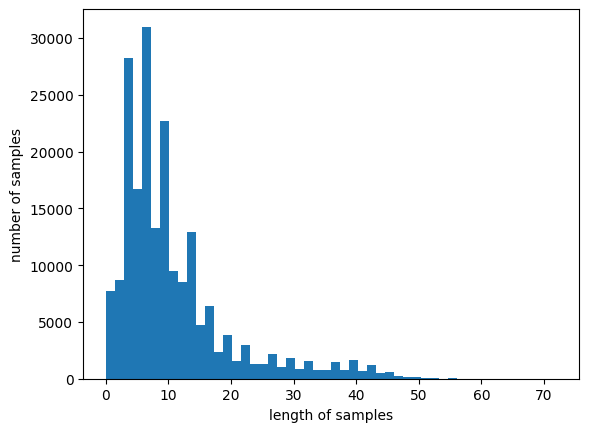

In [45]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### (3) Word2Vec

학습

In [46]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

임베딩 행렬의 크기

In [47]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

유사 단어 추출

In [48]:
print(model.wv.most_similar("최민식"))
print(model.wv.most_similar("히어로"))

[('안성기', 0.8657539486885071), ('한석규', 0.863850474357605), ('최민수', 0.8616666793823242), ('이민호', 0.8597055673599243), ('서영희', 0.8442740440368652), ('이정재', 0.8307631015777588), ('김갑수', 0.8247821927070618), ('김수현', 0.8234200477600098), ('윤제문', 0.821955680847168), ('강지환', 0.8187053799629211)]
[('호러', 0.8734524846076965), ('느와르', 0.8582761883735657), ('슬래셔', 0.855762243270874), ('무협', 0.8441373109817505), ('정통', 0.8283103704452515), ('물', 0.8173542618751526), ('물의', 0.8173313736915588), ('멜로', 0.8134236931800842), ('블록버스터', 0.8105792999267578), ('무비', 0.7990021109580994)]


### 1.1.3 Pretrained Word2Vec embedding

모델 다운로드
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [49]:
# import gensim
# import urllib.request

# # 구글의 사전 훈련된 Word2Vec 모델을 로드.
# urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
#                            filename="GoogleNews-vectors-negative300.bin.gz")
# word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

모델의 크기는 3,000,000 x 300입니다. 즉, 3백만 개의 단어와 각 단어의 차원은 300입니다.

In [50]:
# print(word2vec_model.vectors.shape)

In [51]:
# print(word2vec_model.similarity('this', 'is'))
# print(word2vec_model.similarity('post', 'book'))

### 1.1.4 Skip-Gram with Negative Sampling (SGNS)

In [52]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [53]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


정규화

In [54]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

/var/folders/bk/03p2dw31415ct52_2rx56fmm0000gn/T/ipykernel_8542/1763500723.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [55]:
print(news_df.isnull().values.any())
news_df.replace("", float("NaN"), inplace=True)
print(news_df.isnull().values.any())

False
True


In [56]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [57]:
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [58]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/opt/homebrew/Caskroom/miniforge/base/envs/yeonii/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [59]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [60]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [61]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


네거티브 샘플링을 통한 데이터셋 구성

In [62]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [63]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(subsidizing (15228), quranic (28066)) -> 0
(subsidizing (15228), letter (705)) -> 1
(story (603), reputation (5533)) -> 1
(media (702), salesdroid (52328)) -> 0
(sure (59), crammed (22682)) -> 0


In [64]:
print('전체 샘플 수 :',len(skip_grams))
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

전체 샘플 수 : 10
2220
2220


전체 뉴스 샘플에 대해서 네거티브 샘플링 데이터셋 구성

In [65]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

SGNS 구현

In [66]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [67]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-02-19 16:18:51.976157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 16:18:51.976831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


- 각 임베딩 테이블: 중심 단어와 주변 단어 각각을 위한 임베딩 테이블
- 각 단어는 임베딩 테이블을 거쳐서 내적을 수행
- 내적의 결과는 1 또는 0을 예측하기 위해 시그모이드 함수를 거쳐 최종 예측값 얻음 

In [68]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6427700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                                                              

학습은 5 epoch 수행

In [1]:
# for epoch in tqdm(range(1, 6)):
#     loss = 0
#     for _, elem in enumerate(skip_grams):
#         first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
#         second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
#         labels = np.array(elem[1], dtype='int32')
#         X = [first_elem, second_elem]
#         Y = labels
#         loss += model.train_on_batch(X,Y)  
#     print('Epoch :',epoch, 'Loss :',loss)

결과 확인

In [ ]:
# import gensim

# f = open('./files/vectors.txt' ,'w')
# f.write('{} {}\n'.format(vocab_size-1, embed_size))
# vectors = model.get_weights()[0]
# for word, i in tokenizer.word_index.items():
#     f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
# f.close()

# # 모델 로드
# w2v = gensim.models.KeyedVectors.load_word2vec_format('./files/vectors.txt', binary=False)

단어 벡터 간 유사도 추출

In [3]:
# w2v.most_similar(positive=['soldiers'])

- https://discuss.tensorflow.org/t/mac-os-sonoma-not-compatible-with-latest-tensorflow-metal-libraries/19858/19
- https://forums.developer.apple.com/forums/thread/738644

## 1.2 FastText

In [ ]:
# from gensim.models import FastText

# model = FastText(result, size=100, window=5, min_count=5, workers=4, sg=1)

In [8]:
from gensim.test.utils import common_texts
from gensim.models import FastText

model = FastText(common_texts, vector_size=4, window=3, min_count=1, epochs=10)

sim_score = model.wv.similarity('leaving', 'went')
print(sim_score)

0.49374625


https://jeongmin-d.github.io/NLP_LInk/[Deep_Learning]Word_Embedding(Eng).html

# 2. Count/Prediction Based Embedding

## 2.1 GloVe